<a href="https://colab.research.google.com/github/LeoFernanndes/portfolio/blob/master/CarpriceRegressionDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carprice Dataset Analysis

## Análise exploratória dos dados

##### Instalação das dependências não comuns ao ambiente do google colab

In [126]:
!pip install category_encoders

##### Dataframe com as informações dos preços de revenda dos carros

In [127]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


path='https://raw.githubusercontent.com/LeoFernanndes/datasets/master/automobile_uci_1985.csv'
df_raw = pd.read_csv(path)
df = pd.read_csv(path)

##### Visualização das variáveis do dataframe

In [128]:
df.head()

,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,horsepower-binned,diesel,gas
0,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,0.890278,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,Medium,0,1
1,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,0.890278,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,Medium,0,1
2,1,122,alfa-romero,std,two,hatchback,rwd,front,94.5,0.822681,0.909722,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,Medium,0,1
3,2,164,audi,std,four,sedan,fwd,front,99.8,0.848630,0.919444,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,Medium,0,1
4,2,164,audi,std,four,sedan,4wd,front,99.4,0.848630,0.922222,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,Medium,0,1


In [129]:
df.dtypes

symboling              int64
normalized-losses      int64
make                  object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
city-L/100km         float64
horsepower-binned     object
diesel                 int64
gas                    int64
dtype: object

##### Observando a distribuição dos preços dos carros

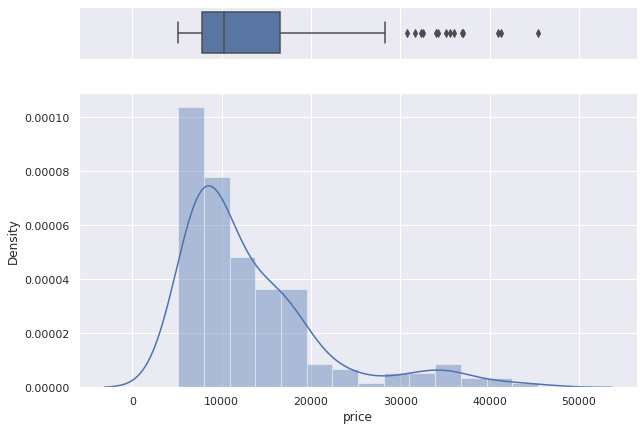

In [130]:
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize': (10, 7)})

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["price"], ax=ax_box)
sns.distplot(df["price"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

plt.show()

##### Visualizando a distribuição dos preços dos carros estratificada em vários níveis de acordo com as variáveis categóricas do dataframe.
Aqui a definição das variáveis a serem selecionadas ou excluídas está explícita nas listas features_to_remove e features_to_append.

Um detalhe a ser ponderado é a avaliação do número de elementos dentro de cada distribução indicado na legenda para uma visualizção um pouco mais clara dos pesos que cada classificação representa em cada curva de custos. Essa análise pode se mostrar interessante na escolha de quais variáveis vão ser priorizadas nos esforços de feature engineering ou clusterização caso decidamos abordar grupos significativamente distintos com modelos de regressão, também dissimilares.



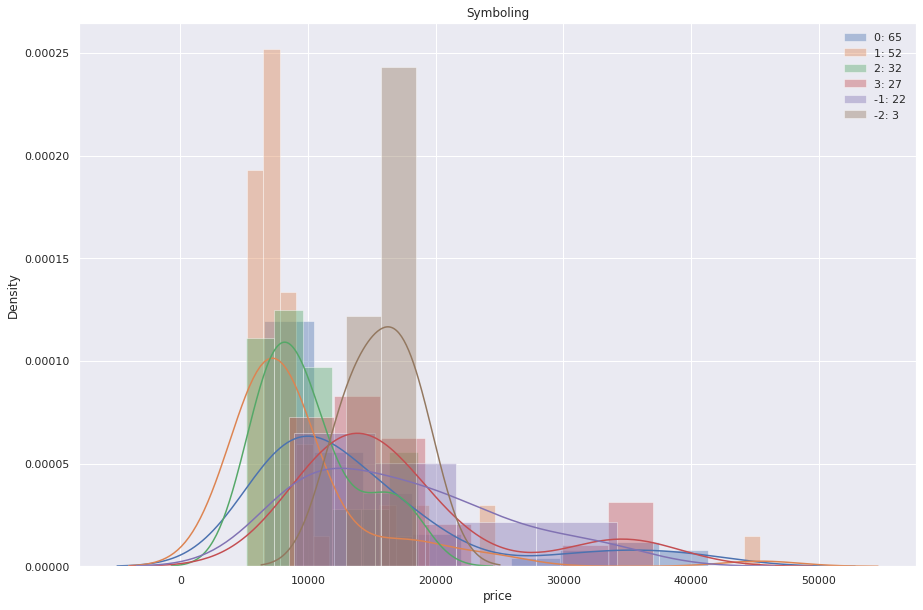

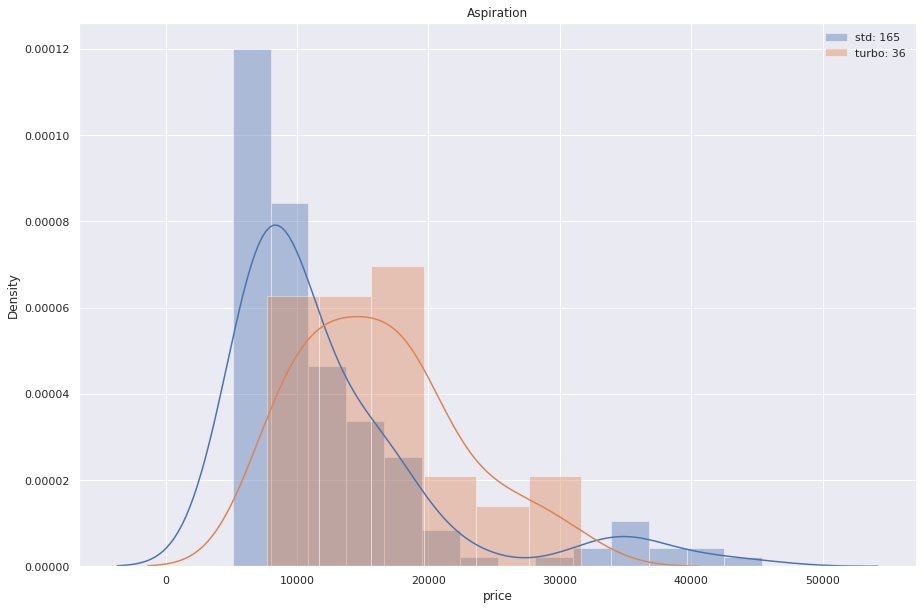

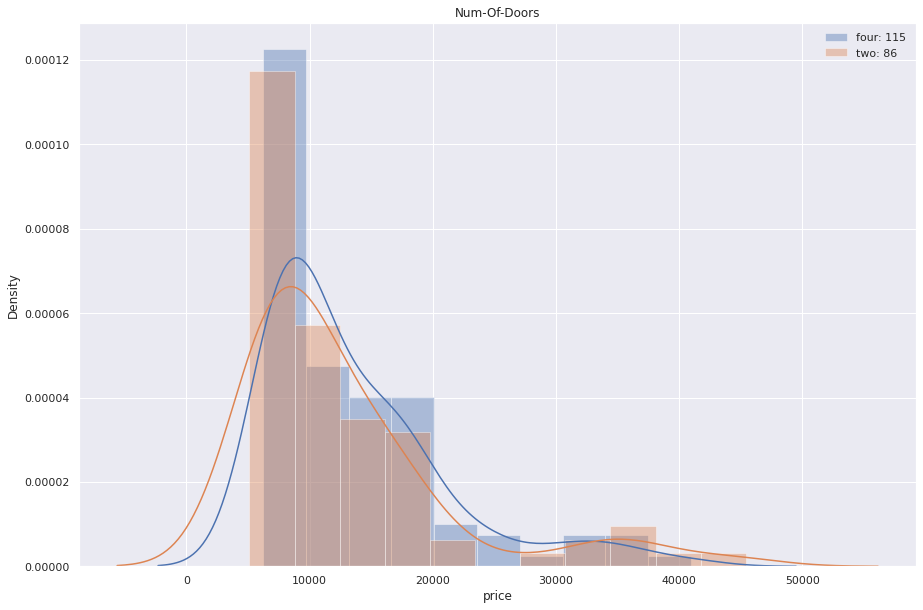

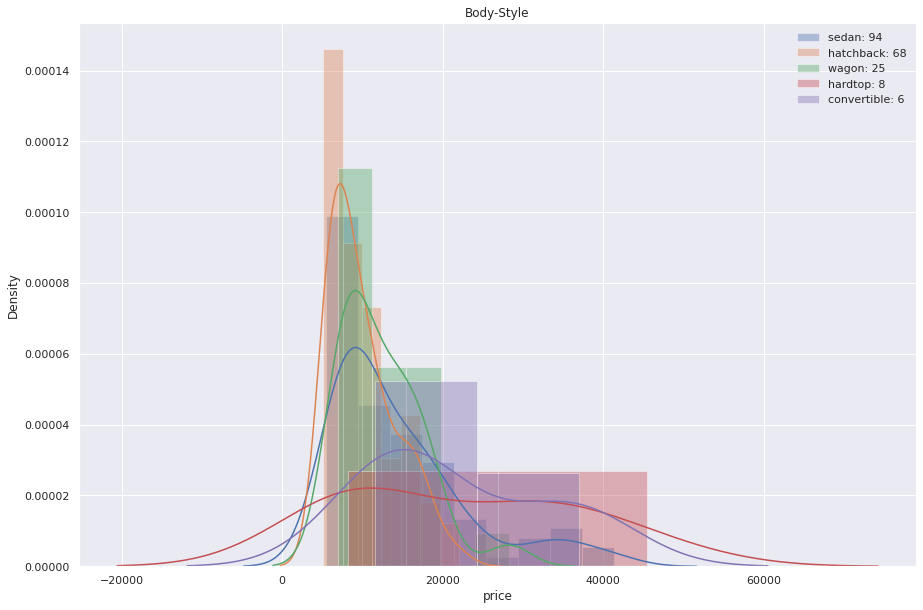

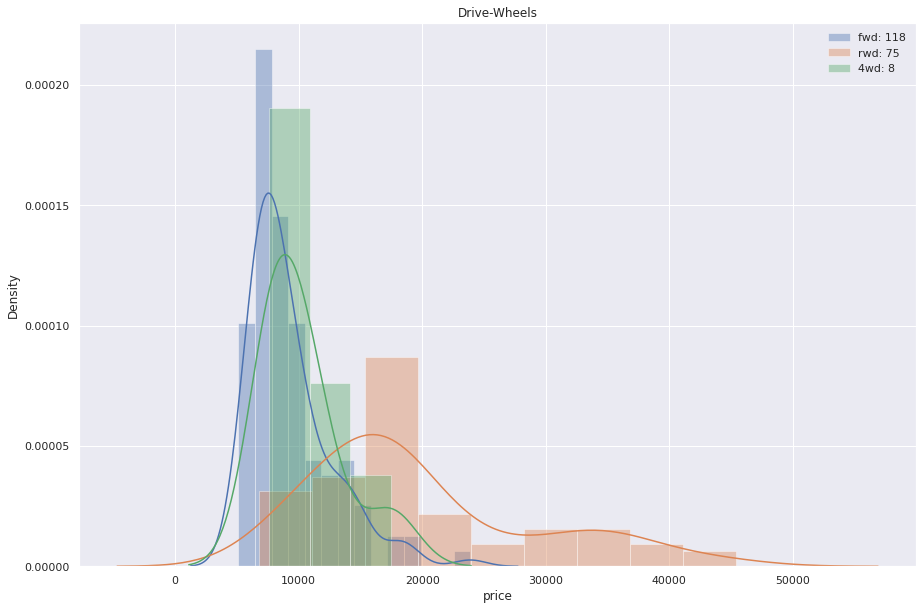

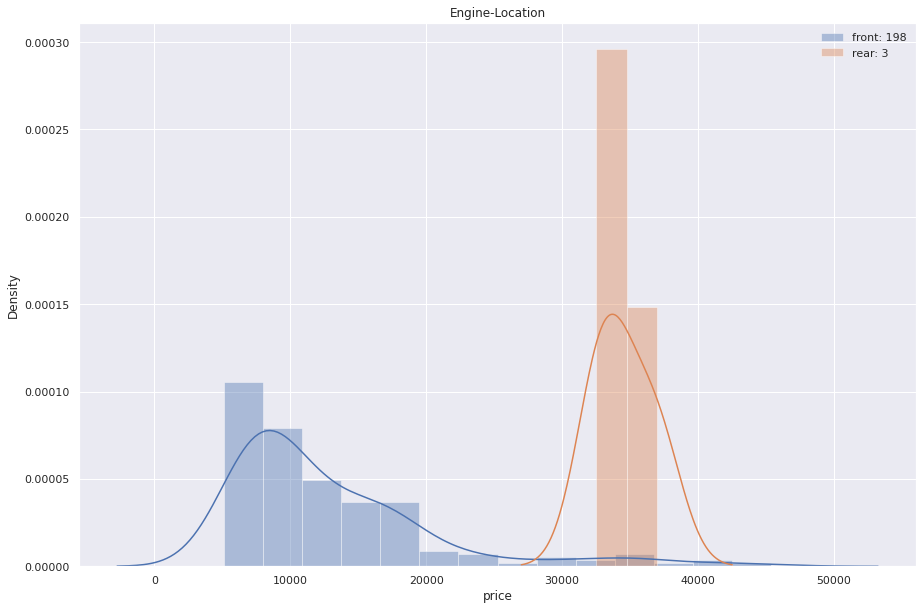

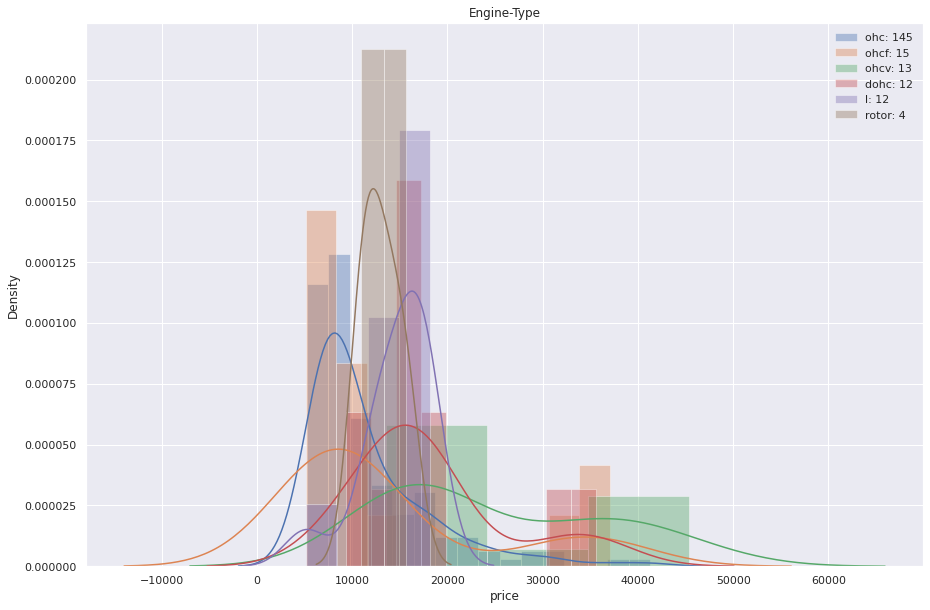

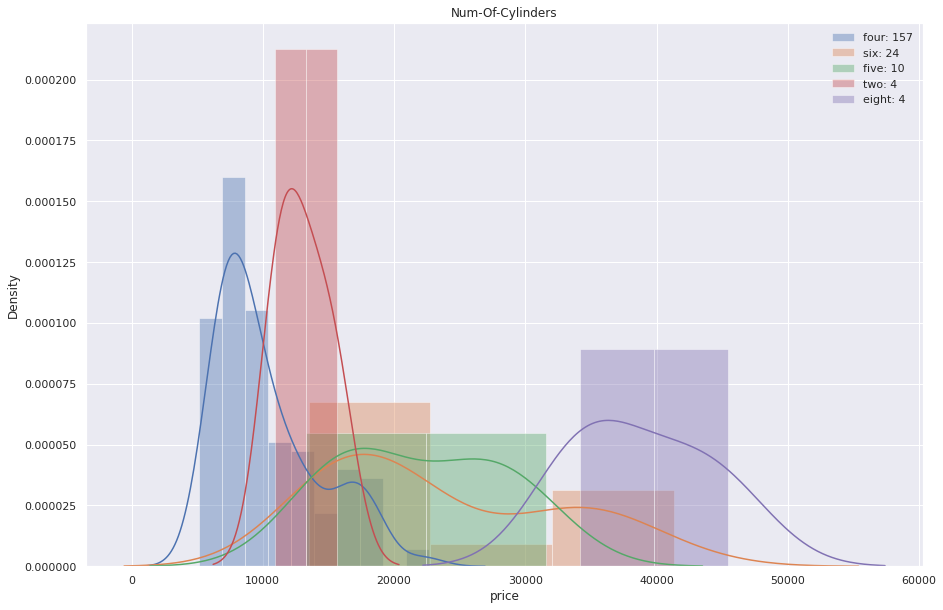

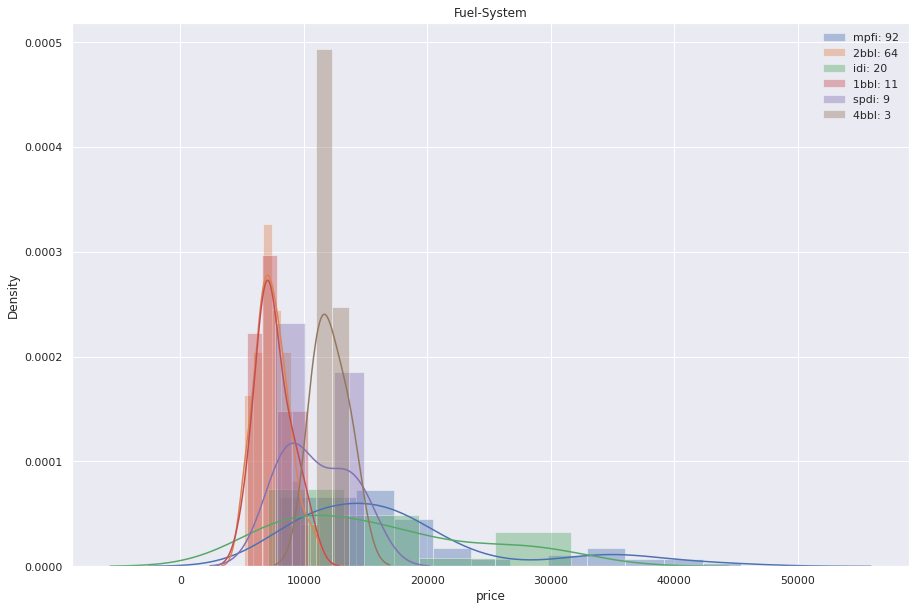

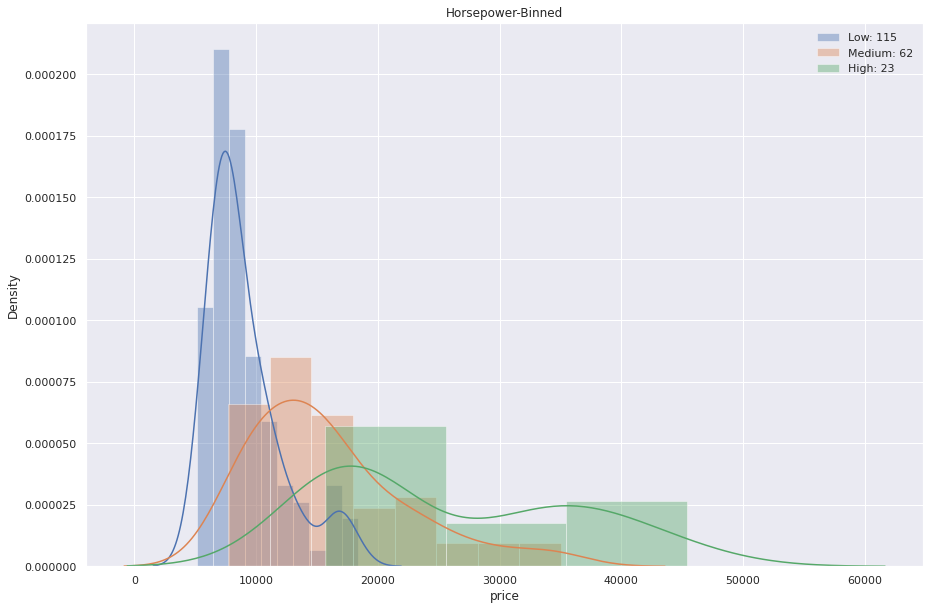

In [131]:
# plotando similaridade entre os preços de cada uma das categorias 

features = list(df.columns)
features_to_remove = ["make"]
features_to_append = ['symboling']
categorical_features = []

plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize': (15, 10),
            })

for feature in features:
  if feature in features_to_remove:
    continue
  if df[feature].dtype == "object" or feature in features_to_append:
    for cls in list(df[feature].value_counts().index):
      if df[feature].value_counts()[cls] > 1:
        sns.distplot(df.loc[df[feature] == cls]['price'], label="{}: {}".format(cls, df[feature].value_counts()[cls]))
    
    plt.legend()
    plt.title('{}'.format(feature.title()))
    plt.show()
    print('')
    categorical_features.append(feature)
  else:
    pass  

##### Box plots para a comparação dessas features categóricas do ponto de vista da presença e distribuição de outiliers

In [132]:
categorical_features

['symboling',
 'aspiration',
 'num-of-doors',
 'body-style',
 'drive-wheels',
 'engine-location',
 'engine-type',
 'num-of-cylinders',
 'fuel-system',
 'horsepower-binned']

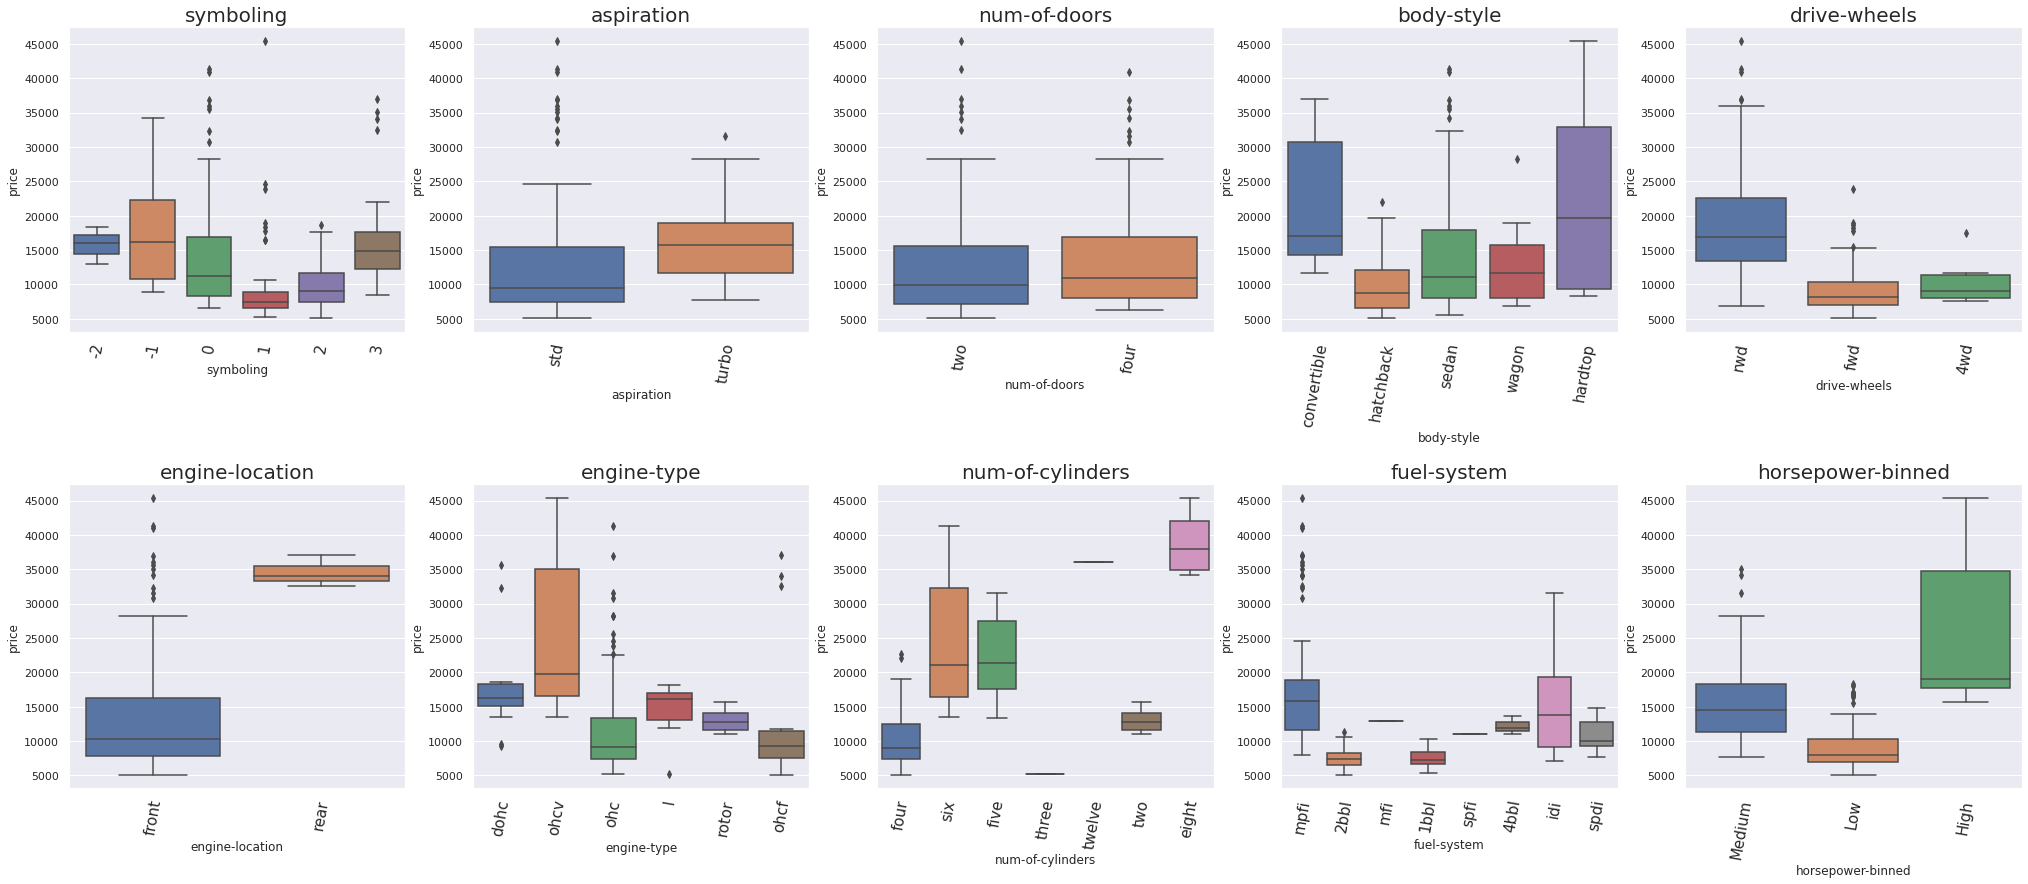

In [133]:
nrows=2
ncols=5
font_size=15

plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize': (7 * ncols, 7 * nrows)})

plt.subplots_adjust(hspace=0.5)
for idx in range(len(categorical_features)):  
  plt.subplot(nrows, ncols, idx+1)
  plt.title("{}".format(categorical_features[idx]), fontsize=20)
  plot2 = sns.boxplot(x=categorical_features[idx], y="price", data=df)
  plt.xticks(rotation=80, fontsize=font_size)

##### Ajustando um polinômio de terceiro grau pra procurar por correlação entre as variáveis numéricas

In [134]:
numerical_features = []
features_to_remove = ['make', 'diesel', 'gas']
for feature in df.columns:
  if feature not in categorical_features and feature not in features_to_remove:
    numerical_features.append(feature)

numerical_features

['normalized-losses',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-size',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'price',
 'city-L/100km']

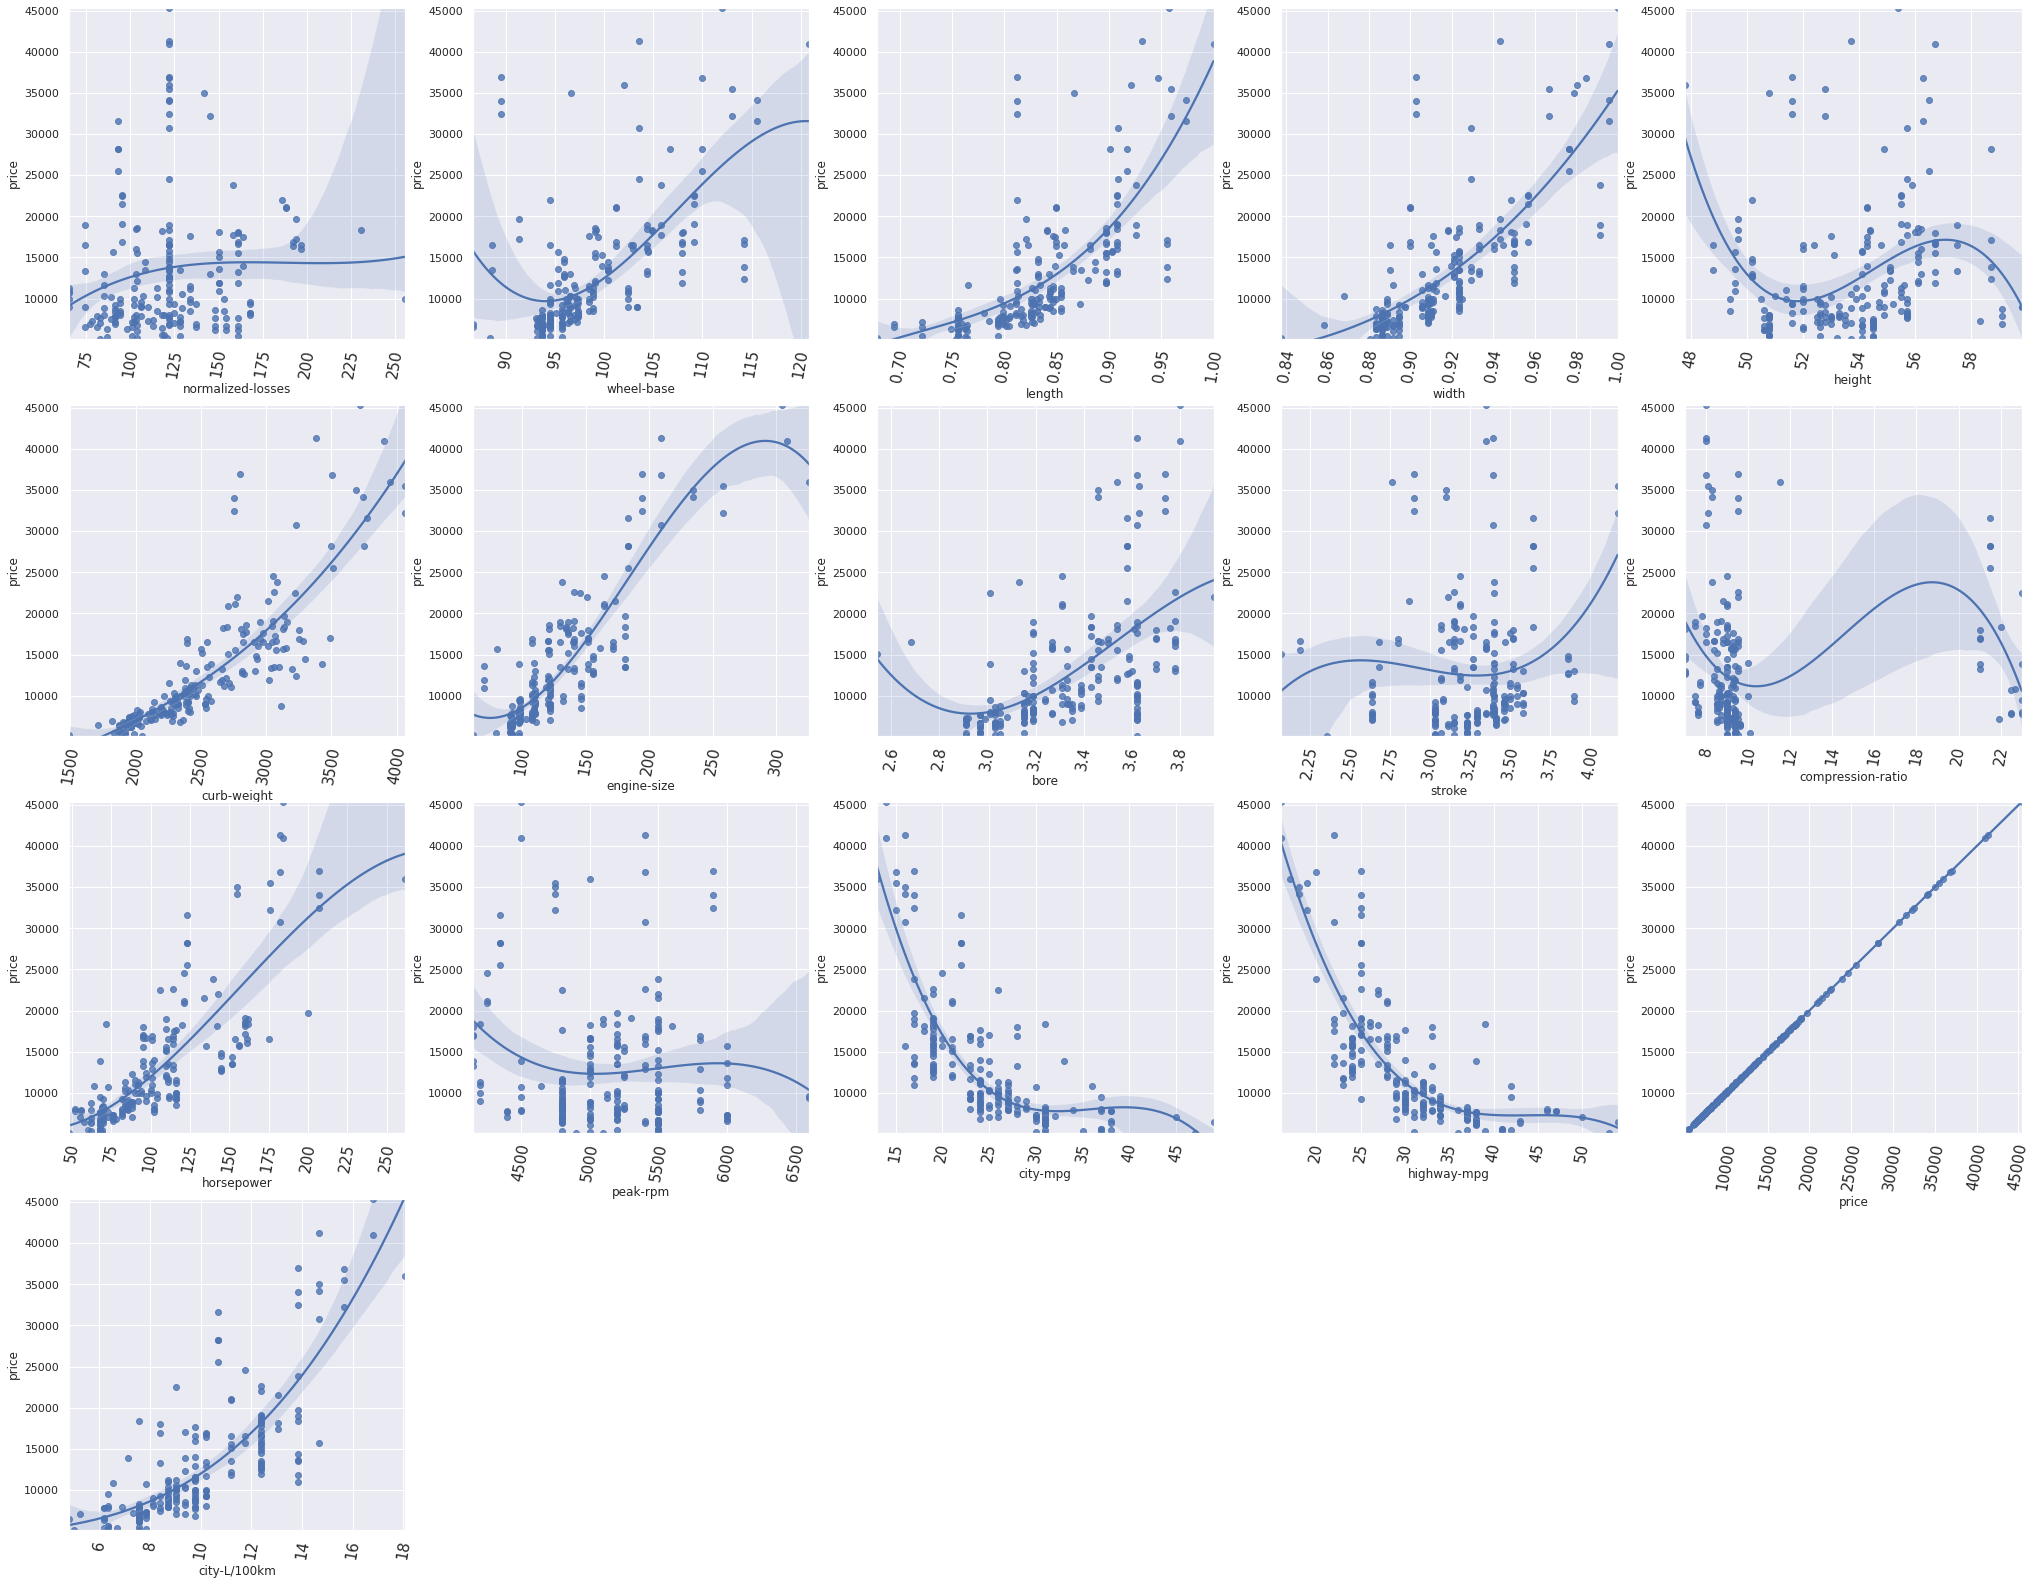

In [135]:
nrows=4
ncols=5
font_size=15

plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize': (7 * ncols, 7 * nrows)})

for idx in range(len(numerical_features)):
  plt.subplot(nrows, ncols, idx+1)
  plot2 = sns.regplot(x=numerical_features[idx], y="price", order=3, data=df)
  plt.xticks(rotation=80, fontsize=font_size)
  plt.ylim((df['price'].min(), df['price'].max()))

Observando a distribuição das variáveis numéricas, podemos ver que algumas são muito pouco correlacionadas como 'stroke', 'compression-ratio' e 'peak-rpm', mas mesmo as que aparentemente mostram uma tendência nos dão conforto o suficiente pra apostar em um modelo de regressão.

In [136]:
def grouped_regression(df, categorical_feature, numerical_feature, target_feature, order=1):
  categories = list(df[categorical_feature].unique())
  plt.style.use('seaborn-whitegrid')
  sns.set(rc={'figure.figsize': (10, 10)})

  for group in categories:
    sns.regplot(x=df.loc[df[categorical_feature] == group][numerical_feature], y=df.loc[df[categorical_feature] == group][target_feature], order=order)
    plt.legend(categories)
    plt.ylim(df[target_feature].min(), df[target_feature].max())

  plt.title(categorical_feature)
  plt.show()

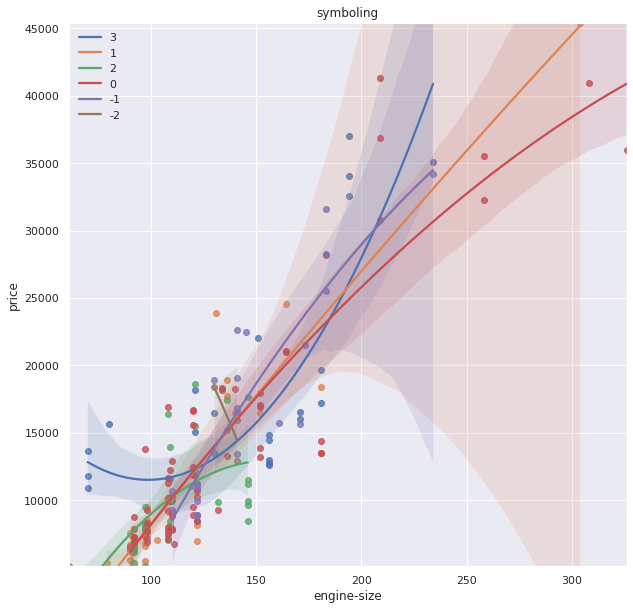

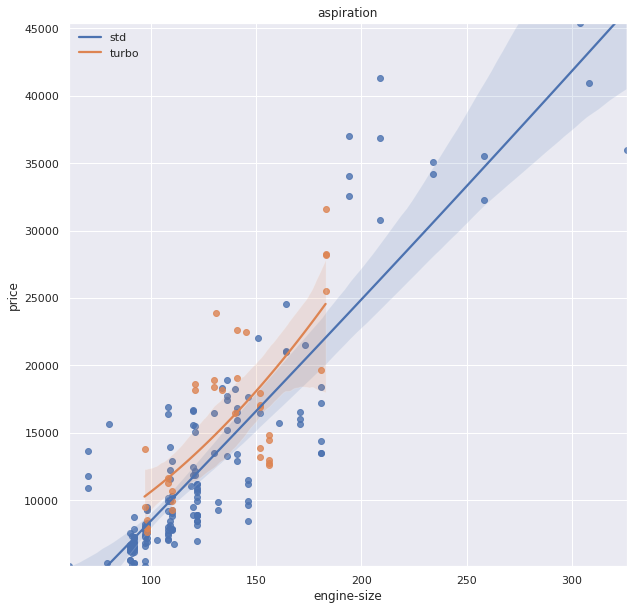

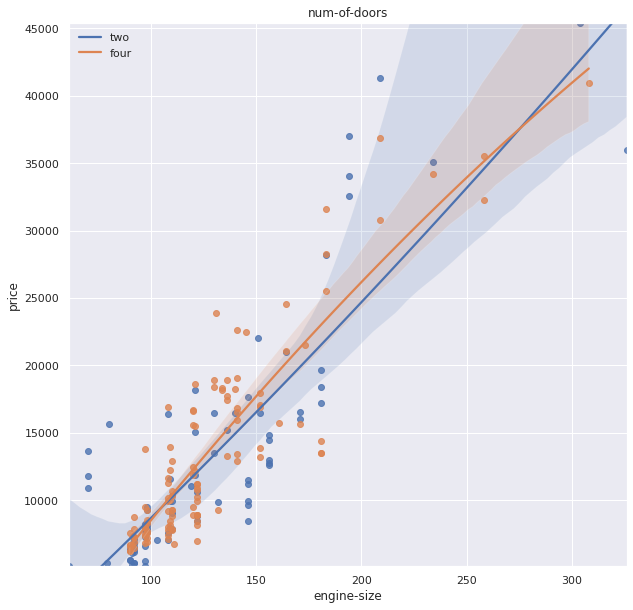

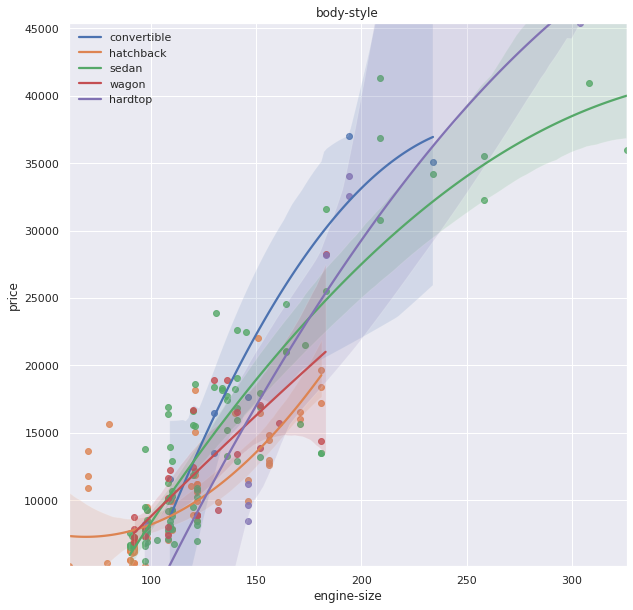

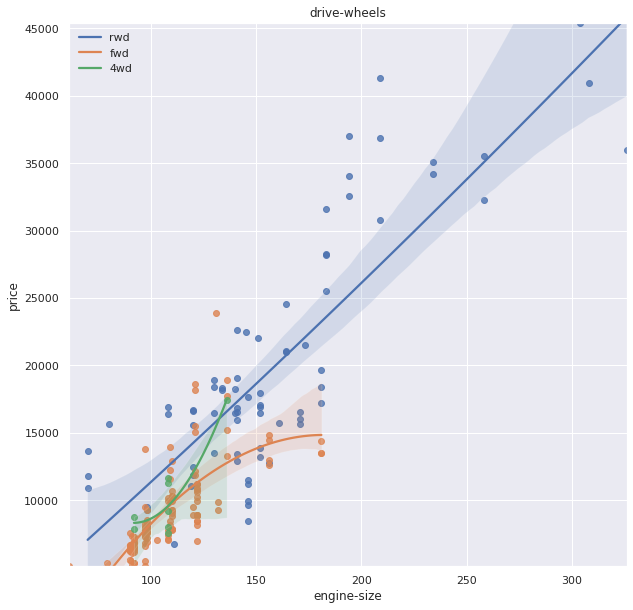

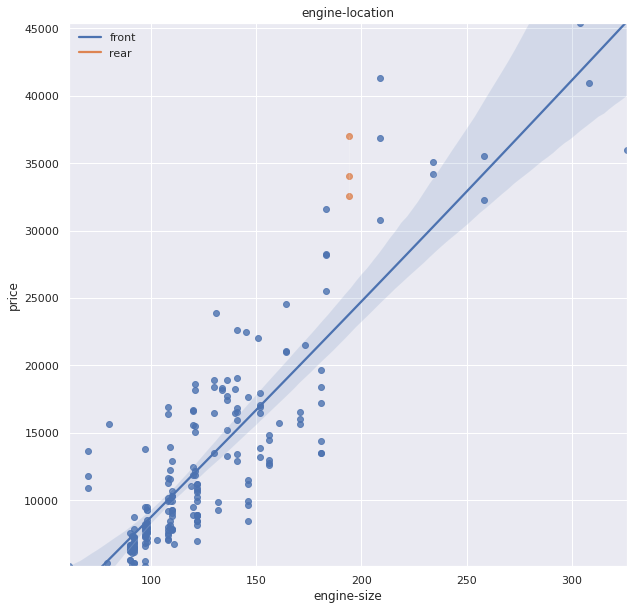

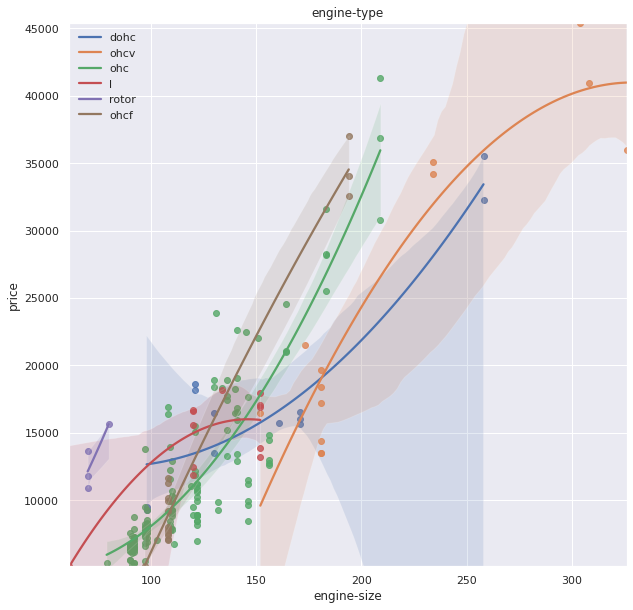

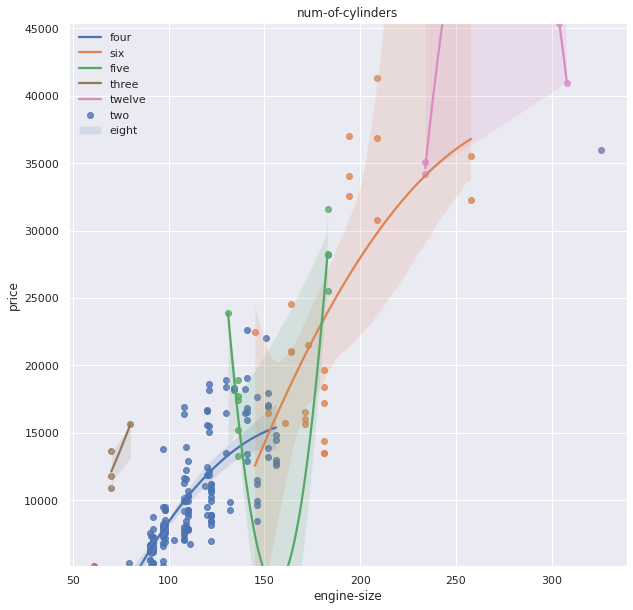

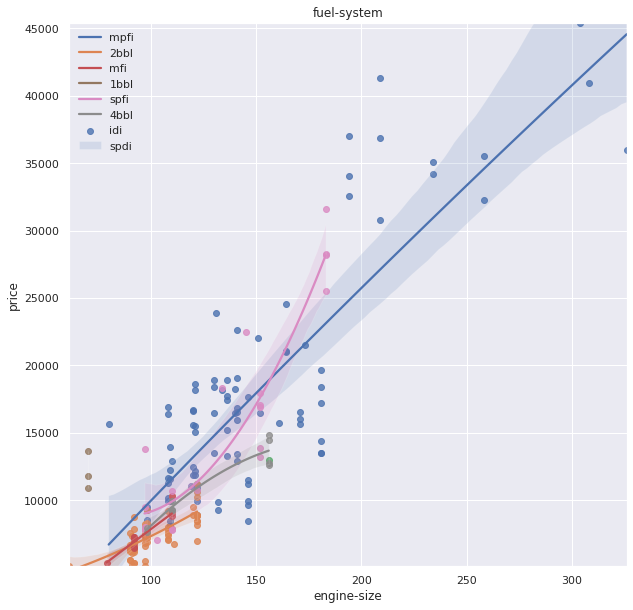

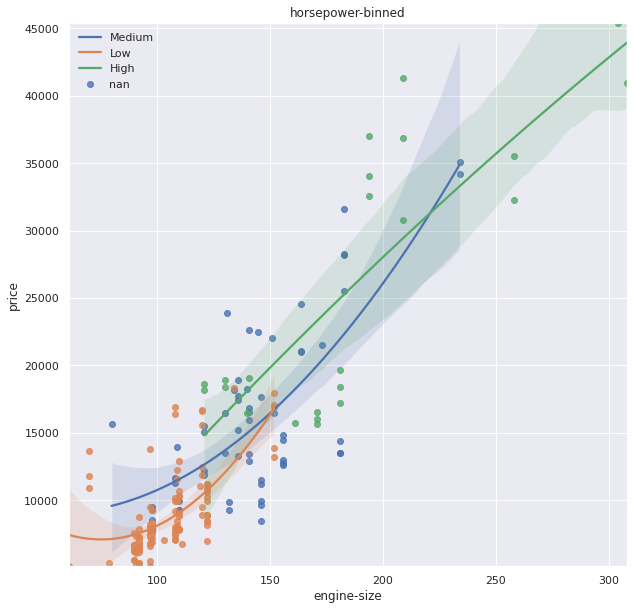

In [150]:
for feature in categorical_features:
  grouped_regression(df, feature, "engine-size", "price", order=2)
  print("")

## Feature engineering

## Definição das funções a serem usadas no pipeline da regressão



##### A função label_encode recebe um dataframe, uma lista com as features e o nome da feature a ser prevista em forma de string. Retorna um dataframe com as features categóricas em formato one-hot e as features numéricas escaladas em min-max.


In [138]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def label_encode(df, features, target):
  new_df = pd.DataFrame(index=df.index)

  for feature in features:
    if df[feature].dtype == "float" or df[feature].dtype == "int":
      new_df[feature] = df[feature].fillna(pd.Series(df[feature].mode().values).median())
      mm = MinMaxScaler()
      if feature != target:
        new_df[feature] = mm.fit_transform(np.array(new_df[feature]).reshape(-1, 1))

    else:
      new_df[feature] = df[feature].fillna(df[feature].mode()[0])
      new_df[feature] = [str(element) for element in new_df[feature]]
      le = LabelEncoder()
      if feature != target:
        new_df[feature] = le.fit_transform(new_df[feature])
    
  return new_df

##### A função split_train_test_index recebe um dataframe e um float opcional com a fração do dataframe reservada para os testes e retorna o dataframe de treino e o dataframe de teste com índices separados randomicamente.

In [139]:
from random import randint
import random

def split_train_test_index(df, percentual_test = 0.3): 
  len_df = df.shape[0]
  train_index = []
  test_index = []
  
  while len(test_index) < len_df * percentual_test:
    rand = random.choice(list(df.index))
    if rand not in test_index:
      test_index.append(rand)

  for value in list(df.index):
    if value not in test_index:
      train_index.append(value)

  return df.loc[train_index], df.loc[test_index]

##### A função valid_train_test_index recebe um dataframe, o nome da variável a ser prevista em formato de string e os parâmetros opcionais de fração do dataframe reservada para testes, diferença limite entre as médias da amostra de treino e teste e diferença limite entre os desvios padrão das amostras de treino e teste.
Realiza um processo iterativo de separação em treino e teste até que as amostras cumpram os requisitos definidos e retorna o dataframe de treino e o dataframe de teste.

obs.: aqui pode surgir uma inconsistência com a seleção da amostra em casos de não normalidade das distribuições da variável prevista mas nos testes, a combinação de média e std mesmo para o caso dos preços de revenda de carros que não segue uma distribuição normal, a similaridade é consistente.

In [140]:
def valid_train_test_index(new_df, test_size=0.3, percentual_mean_treshold=0.01, percentual_std_treshold=0.1):
  '''
  Tomar cuidado com possíveis recursoes infinitas quando as amostras não
  conseguem atingir um limite de similaridade exigido pra saída do loop
  '''
  train_mean_price = 0.9
  test_mean_price = 0.5
  train_std_price = 0.91
  test_std_price = 0.51
  
  train_df = 0
  test_df = 0

  while ((abs(train_mean_price - test_mean_price) / train_mean_price) > percentual_mean_treshold or
        (abs(train_std_price - test_std_price) / train_std_price) > percentual_std_treshold):

    train_df, test_df = split_train_test_index(new_df, test_size)

    train_mean_price = train_df['price'].mean()
    test_mean_price = test_df['price'].mean()
    train_std_price = train_df['price'].std()
    test_std_price = test_df['price'].std()

  return train_df, test_df

##### A função make_predictions recebe os dataframes de treino e teste, o nome da variavel a ser prevista e como parâmetros opcionais, o número de iterações e um objeto do modelo que vai ser usado na regressão. Retorna um dataframe contendo os resultados da regressão.

obs.: aqui temos uma possível investigação a ser realizada. Quando selecionamos 80% da amostra de treino, ela dificilmente mantém o mesmo perfil. Podemos fazer testes com uma separação novamente em amostras que mantenham o formato da distribuição para verificar se existe impacto.

In [141]:
from sklearn.ensemble import RandomForestRegressor

def make_predictions(train_df, test_df, target, iterations=100, model=RandomForestRegressor()):
  from sklearn.model_selection import train_test_split
  from sklearn.ensemble import RandomForestRegressor

  df_results = pd.DataFrame(index=test_df.index)
  
  for i in range(iterations):
    x_train, x_out, y_train, y_out = train_test_split(train_df.drop(columns=[target]), train_df[target], train_size=0.8)
    model.fit (x_train, y_train)
    y_pred = model.predict(test_df.drop(columns=[target])) 
    df_results[i] = y_pred

  return df_results

##### A função compute_metrics recebe o dataframe de resultados e o dataframe de testes e retorna um dataframe com as metricas de erro absoluto, raíz do erro médio e erro percentual.

In [142]:
def compute_metrics(df_results, test_df):  
  absolute_error = []
  rmse = []
  percentual_error = []

  for idx in df_results.index:
    y_pred_median = df_results.loc[idx].T.median()
    y_real = test_df.loc[idx]['price']

    absolute_error_ = y_real - y_pred_median
    absolute_error.append(absolute_error_)

    rmse_ = np.sqrt((y_real - y_pred_median) ** 2)
    rmse.append(rmse_)

    percentual_error_ = (y_real - y_pred_median) / y_real
    percentual_error.append(percentual_error_)
    
  df_metrics = pd.DataFrame({
      "index": df_results.index,
      "absolute_error": absolute_error,
      "rmse": rmse,
      "percentual_error": percentual_error
  })

  return df_metrics

## Regressão

##### Regressão em cima dos dados sem qualquer tipo de seleção

In [143]:
mean_metric = []
std_metric = []

for i in range(10):
  encoded_df = label_encode(df, df.columns, 'price')
  valid_train_df, valid_test_df = valid_train_test_index(encoded_df, percentual_mean_treshold=0.02, percentual_std_treshold=0.02)
  prediction_df = make_predictions(valid_train_df, valid_test_df, 'price')
  metrics_df = compute_metrics(prediction_df, valid_test_df)  

  mean_metric.append(metrics_df['percentual_error'].mean())
  std_metric.append(metrics_df['percentual_error'].std())
  print("{} +- {}".format(metrics_df['percentual_error'].mean(), metrics_df['percentual_error'].std()))

print("")
print("{} +- {}".format(pd.Series(mean_metric).mean(), pd.Series(std_metric).mean()))

-0.023308647792692136 +- 0.1601065918009195
-0.02898581026966095 +- 0.1387132803602216
0.016419986925437294 +- 0.12441693117228754
0.0015220616719208403 +- 0.141149020359009
-0.032249859983991054 +- 0.1598471311430481
-0.004990840173616845 +- 0.14855825758575808
-0.020657462475020667 +- 0.12153163587597633
-0.004957704571078395 +- 0.12622636479180652
-0.017415617916789625 +- 0.13157260570037385
-0.015084961426183046 +- 0.16724316346372778

-0.01297088560116746 +- 0.14193649822531282


##### Regressão com a remoção dos outliers da variável alvo

In [144]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQ = Q3 - Q1
LI = Q1 - 1.5 * IQ
LS = Q3 + 1.5 * IQ

df_sem_outliers_price = df.loc[(df['price'] > LI) & (df['price'] < LS)]

mean_metric = []
std_metric = []



for i in range(10):
  encoded_df = label_encode(df_sem_outliers_price, df.columns, 'price')
  valid_train_df, valid_test_df = valid_train_test_index(encoded_df, percentual_mean_treshold=0.02, percentual_std_treshold=0.02)
  prediction_df = make_predictions(valid_train_df, valid_test_df, 'price')
  metrics_df = compute_metrics(prediction_df, valid_test_df)

  mean_metric.append(metrics_df['percentual_error'].mean())
  std_metric.append(metrics_df['percentual_error'].std())
  print("{} +- {}".format(metrics_df['percentual_error'].mean(), metrics_df['percentual_error'].std()))

print("")
print("{} +- {}".format(pd.Series(mean_metric).mean(), pd.Series(std_metric).mean()))

-0.002163671508472317 +- 0.12473415755829503
-0.019689650799778236 +- 0.13735386595046561
-0.030717685525905918 +- 0.14167561802358442
-0.02187239505112199 +- 0.1253362259164576
-0.016262322708713625 +- 0.11704530450215442
-0.012625407352413437 +- 0.16399454504724686
-0.00861833382378262 +- 0.12481457527273916
-0.017599326774887424 +- 0.15328472752202593
-0.006353457866358825 +- 0.09950764592737474
-0.012229455040899447 +- 0.15037184495769046

-0.014813170645233385 +- 0.13381185106780344


Vemos aqui que a remoção dos outliers da variável preço não trouxe melhorias ao modelo. 

Vamos fazer, então, experimentos explorando as relações um pouco menos evidentes

In [145]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQ = Q3 - Q1
LI = Q1 - 1.5 * IQ
LS = Q3 + 1.5 * IQ

features = ['highway-mpg', 'price']
df_sem_outliers_price = df.loc[(df['price'] > LI) & (df['price'] < LS)]
df_sem_outliers_price = df_sem_outliers_price[features]

mean_metric = []
std_metric = []

for i in range(10):
  encoded_df = label_encode(df_sem_outliers_price, df_sem_outliers_price.columns, 'price')
  valid_train_df, valid_test_df = valid_train_test_index(encoded_df, percentual_mean_treshold=0.02, percentual_std_treshold=0.02)
  prediction_df = make_predictions(valid_train_df, valid_test_df, 'price')
  metrics_df = compute_metrics(prediction_df, valid_test_df)

  mean_metric.append(metrics_df['percentual_error'].mean())
  std_metric.append(metrics_df['percentual_error'].std())
  print("{} +- {}".format(metrics_df['percentual_error'].mean(), metrics_df['percentual_error'].std()))

print("")
print("{} +- {}".format(pd.Series(mean_metric).mean(), pd.Series(std_metric).mean()))

-0.0328040696720476 +- 0.2929231923772889
-0.09663779395528524 +- 0.2883869251901445
-0.03611124933921299 +- 0.2979440994035914
-0.04799253096532648 +- 0.24981299675530377
-0.05210783624896635 +- 0.264455012242204
-0.03286844618466344 +- 0.20605980328147097
-0.05409437040051707 +- 0.2140792597479203
-0.08915152556652942 +- 0.22844829253909626
0.013347537339622325 +- 0.2192743051589724
-0.03167287357834921 +- 0.18752153799818524

-0.046009315857127545 +- 0.2448905424694178


In [148]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQ = Q3 - Q1
LI = Q1 - 1.5 * IQ
LS = Q3 + 1.5 * IQ

features = df.columns
df_sem_outliers_price = df.loc[(df['price'] > LI) & (df['price'] < LS)]
df_sem_outliers_price = df_sem_outliers_price[features]

for group in list(df_sem_outliers_price[feature].value_counts().index):
  df_horsepower_binned = df_sem_outliers_price.loc[df_sem_outliers_price[feature] == group][features].dropna()

  encoded_df = label_encode(df_horsepower_binned, df_horsepower_binned.columns, 'price')
  valid_train_df, valid_test_df = valid_train_test_index(encoded_df, percentual_mean_treshold=0.02, percentual_std_treshold=0.02)
  prediction_df = make_predictions(valid_train_df, valid_test_df, 'price')
  metrics_df = compute_metrics(prediction_df, valid_test_df)
  print(group, metrics_df['percentual_error'].mean(), metrics_df['percentual_error'].std())

Low -0.06161148807812524 0.18279789075908998
Medium -0.01124493837053016 0.1662530106478836
High 0.00650013886985361 0.0751365149823519
